In [7]:
import yfinance as yf
import datetime
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2020, 1, 1)
YEARS = (END - START).days / 365.25

In [3]:
STARTING_BALANCE = 10000

In [24]:
tickerData = yf.Ticker('^GSPC')
price = tickerData.history(period='1d', start=START, end=END)
# price = pdr.get_data_yahoo('^SPX', start=START, end=END)
price.tail()

Open        High         Low       Close  \
Date                                                                        
2019-12-24 00:00:00-05:00  262.011868  263.178114  261.250422  262.648010   
2019-12-26 00:00:00-05:00  263.447983  264.411828  262.580527  263.669678   
2019-12-27 00:00:00-05:00  264.517862  264.922661  262.541990  264.373291   
2019-12-30 00:00:00-05:00  264.460032  264.807002  261.211876  262.108246   
2019-12-31 00:00:00-05:00  261.693738  263.419001  261.057597  263.178040   

                           Volume  Dividends  Stock Splits  
Date                                                        
2019-12-24 00:00:00-05:00  363000        0.0           0.0  
2019-12-26 00:00:00-05:00  450300        0.0           0.0  
2019-12-27 00:00:00-05:00  688800        0.0           0.0  
2019-12-30 00:00:00-05:00  539000        0.0           0.0  
2019-12-31 00:00:00-05:00  638900        0.0           0.0

In [25]:
price = price.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)
price.tail()

Close
Date                                 
2019-12-24 00:00:00-05:00  262.648010
2019-12-26 00:00:00-05:00  263.669678
2019-12-27 00:00:00-05:00  264.373291
2019-12-30 00:00:00-05:00  262.108246
2019-12-31 00:00:00-05:00  263.178040

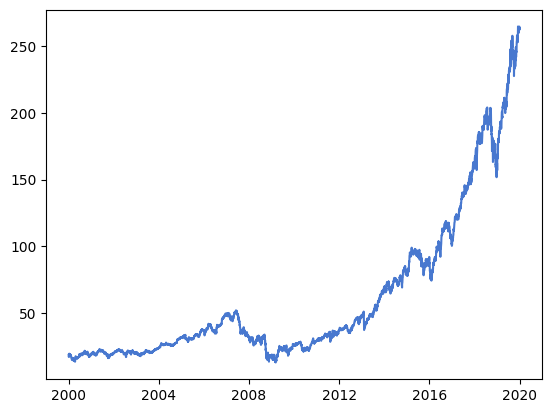

In [31]:
# print(plt.style.available)
plt.style.use('seaborn-v0_8-muted')
plt.plot(price.Close)
plt.show()

In [34]:
# price['Return'] = price['Close'].pct_change()
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price

Close    Return      Bench_Bal
Date                                                          
2000-01-03 00:00:00-05:00   18.910179  1.000000   10000.000000
2000-01-04 00:00:00-05:00   18.040508  0.954010    9540.104374
2000-01-05 00:00:00-05:00   17.797812  0.986547    9411.762511
2000-01-06 00:00:00-05:00   17.312418  0.972727    9155.078785
2000-01-07 00:00:00-05:00   17.474216  1.009346    9240.640363
...                               ...       ...            ...
2019-12-24 00:00:00-05:00  262.648010  1.004164  138892.396701
2019-12-26 00:00:00-05:00  263.669678  1.003890  139432.670525
2019-12-27 00:00:00-05:00  264.373291  1.002669  139804.752289
2019-12-30 00:00:00-05:00  262.108246  0.991432  138606.960798
2019-12-31 00:00:00-05:00  263.178040  1.004081  139172.684525

[5031 rows x 3 columns]

In [35]:
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
bench_dd

-74.67

In [36]:
# calculate MACD
exp1 = price.Close.ewm(span=12, adjust=False).mean()
exp2 = price.Close.ewm(span=26, adjust=False).mean()

macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()

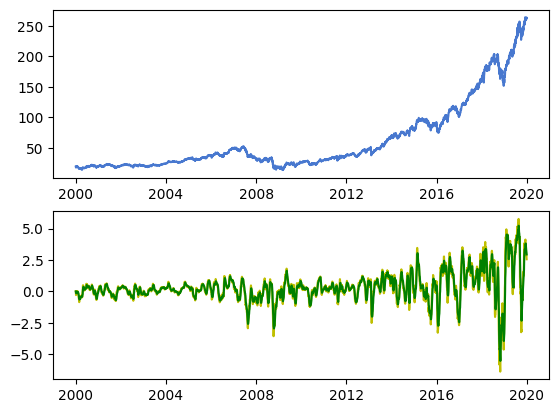

In [38]:
plt.figure()
plt.subplot(211)
plt.plot(price.Close)

plt.subplot(212)
plt.plot(macd, label='SPGI MACD', color='y')
plt.plot(signal, label='Signal Line', color='g')
plt.show()

In [40]:
# add entries
price['Long'] = macd > signal
price.tail()

Close    Return      Bench_Bal     Bench_Peak  \
Date                                                                            
2019-12-24 00:00:00-05:00  262.648010  1.004164  138892.396701  139850.633121   
2019-12-26 00:00:00-05:00  263.669678  1.003890  139432.670525  139850.633121   
2019-12-27 00:00:00-05:00  264.373291  1.002669  139804.752289  139850.633121   
2019-12-30 00:00:00-05:00  262.108246  0.991432  138606.960798  139850.633121   
2019-12-31 00:00:00-05:00  263.178040  1.004081  139172.684525  139850.633121   

                              Bench_DD   Long  
Date                                           
2019-12-24 00:00:00-05:00  -958.236420  False  
2019-12-26 00:00:00-05:00  -417.962596  False  
2019-12-27 00:00:00-05:00   -45.880832  False  
2019-12-30 00:00:00-05:00 -1243.672322  False  
2019-12-31 00:00:00-05:00  -677.948596  False

In [42]:
# calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()
price

Close    Return      Bench_Bal     Bench_Peak  \
Date                                                                            
2000-01-03 00:00:00-05:00   18.910179  1.000000   10000.000000   10000.000000   
2000-01-04 00:00:00-05:00   18.040508  0.954010    9540.104374   10000.000000   
2000-01-05 00:00:00-05:00   17.797812  0.986547    9411.762511   10000.000000   
2000-01-06 00:00:00-05:00   17.312418  0.972727    9155.078785   10000.000000   
2000-01-07 00:00:00-05:00   17.474216  1.009346    9240.640363   10000.000000   
...                               ...       ...            ...            ...   
2019-12-24 00:00:00-05:00  262.648010  1.004164  138892.396701  139850.633121   
2019-12-26 00:00:00-05:00  263.669678  1.003890  139432.670525  139850.633121   
2019-12-27 00:00:00-05:00  264.373291  1.002669  139804.752289  139850.633121   
2019-12-30 00:00:00-05:00  262.108246  0.991432  138606.960798  139850.633121   
2019-12-31 00:00:00-05:00  263.178040  1.004081  139172.684525  139850.633121   

                              Bench_DD   Long  Sys_Ret       Sys_Bal  
Date                                                                  
2000-01-03 00:00:00-05:00     0.000000  False      1.0  10000.000000  
2000-01-04 00:00:00-05:00  -459.895626  False      1.0  10000.000000  
2000-01-05 00:00:00-05:00  -588.237489  False      1.0  10000.000000  
2000-01-06 00:00:00-05:00  -844.921215  False      1.0  10000.000000  
2000-01-07 00:00:00-05:00  -759.359637  False      1.0  10000.000000  
...                                ...    ...      ...           ...  
2019-12-24 00:00:00-05:00  -958.236420  False      1.0  24076.119116  
2019-12-26 00:00:00-05:00  -417.962596  False      1.0  24076.119116  
2019-12-27 00:00:00-05:00   -45.880832  False      1.0  24076.119116  
2019-12-30 00:00:00-05:00 -1243.672322  False      1.0  24076.119116  
2019-12-31 00:00:00-05:00  -677.948596  False      1.0  24076.119116  

[5031 rows x 8 columns]

In [43]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round((price.Sys_DD / price.Sys_Peak).min() * 100, 2)

sys_dd

-56.13

In [44]:
#calculate metrics
bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
sys_ret = round(((price.Sys_Bal[-1]/price.Sys_Bal[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}%')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_ret}%')
print(f'System CAGR: {sys_cagr}%')
print(f'System DD: {sys_dd}%')

Benchmark Total return: 1291.73%
Benchmark CAGR: 14.07%
Benchmark DD: -74.67%

System Total return: 140.76%
System CAGR: 4.49%
System DD: -56.13%


/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_24381/1587932551.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_24381/1587932551.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_24381/1587932551.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

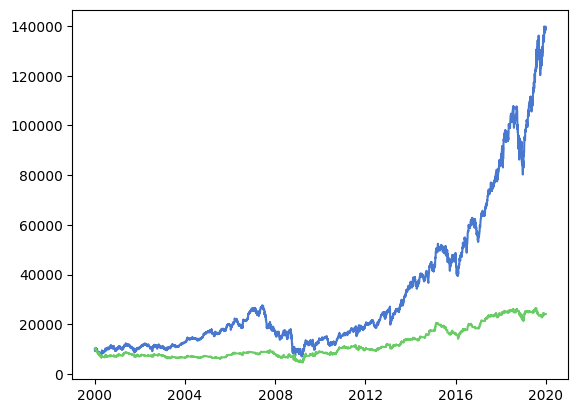

In [45]:
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal)

plt.show()

In [46]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225']

In [51]:
#create backtesting function
def backtest(symbol):
    #download data
    tickerData = yf.Ticker(symbol)
    price = tickerData.history(period='1d', start=START, end=END)

    # price = pdr.get_data_yahoo(symbol, START, END)

    #remove columns
    price = price.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

    # price = price.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], 1)

    #calculate daily return
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

    #calculate drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    #calculate MACD
    exp1 = price.Close.ewm(span=12, adjust=False).mean()
    exp2 = price.Close.ewm(span=26, adjust=False).mean()

    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()

    #add column for long entries based on MACD signal
    price['Long'] = macd > signal

    #calculate system return and balance
    price['Sys_Return'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Return.cumprod()

    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

    #calculate metrics
    bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
    bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_return = round(((price.Sys_Bal[-1]/price.Sys_Bal[0]) - 1) * 100, 2)
    sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

    return bench_cagr, sys_cagr

In [52]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_24381/1106338406.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_24381/1106338406.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_24381/1106338406.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

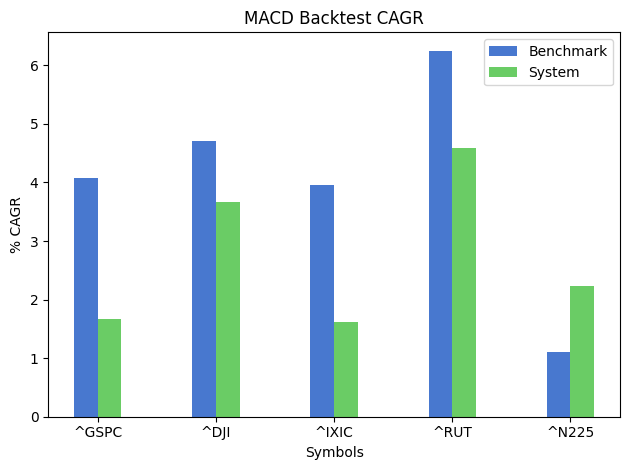

In [53]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark')
plt.bar(x_indices + width / 2, sc, width = width, label = 'System')

plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('MACD Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.show()